<a href="https://colab.research.google.com/github/satani99/practical_deep_learning_for_coders/blob/main/fast_ai_6.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from fastai.vision.all import *
path = untar_data(URLs.PASCAL_2007)

In [3]:
df = pd.read_csv(path/'train.csv')
df.head()

,fname,labels,is_valid
0,000005.jpg,chair,True
1,000007.jpg,car,True
2,000009.jpg,horse person,True
3,000012.jpg,car,False
4,000016.jpg,bicycle,True


In [4]:
df.iloc[:,0]

0       000005.jpg
1       000007.jpg
2       000009.jpg
3       000012.jpg
4       000016.jpg
           ...    
5006    009954.jpg
5007    009955.jpg
5008    009958.jpg
5009    009959.jpg
5010    009961.jpg
Name: fname, Length: 5011, dtype: object

In [5]:
df.iloc[0,:]

fname       000005.jpg
labels           chair
is_valid          True
Name: 0, dtype: object

In [6]:
df['fname']

0       000005.jpg
1       000007.jpg
2       000009.jpg
3       000012.jpg
4       000016.jpg
           ...    
5006    009954.jpg
5007    009955.jpg
5008    009958.jpg
5009    009959.jpg
5010    009961.jpg
Name: fname, Length: 5011, dtype: object

In [7]:
df1 = pd.DataFrame()
df1['a'] = [1, 2, 3, 4]
df1

,a
0,1
1,2
2,3
3,4


In [9]:
df1['b'] = [10, 20, 30, 40]
df1['c'] = df1['a'] + df1['b']
df1

,a,b,c
0,1,10,11
1,2,20,22
2,3,30,33
3,4,40,44


In [10]:
dblock = DataBlock()

In [11]:
dsets = dblock.datasets(df)

In [12]:
dsets.train[0]

(fname             006876.jpg
 labels      chair person cat
 is_valid                True
 Name: 3469, dtype: object, fname             006876.jpg
 labels      chair person cat
 is_valid                True
 Name: 3469, dtype: object)

In [15]:
dblock = DataBlock(get_x = lambda r: r['fname'], get_y = lambda r: r['labels'])
dsets = dblock.datasets(df)
dsets.valid[0]

('009331.jpg', 'horse person dog')

In [18]:
def get_x(r): return path/'train'/r['fname']
def get_y(r): return r['labels'].split(' ')
dblock = DataBlock(blocks=(ImageBlock, MultiCategoryBlock), get_x = get_x, get_y = get_y)
dsets = dblock.datasets(df)
dsets.train[0]

(PILImage mode=RGB size=375x500,
 TensorMultiCategory([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 1.,
                      0., 0., 0., 0., 0.]))

In [19]:
idxs = torch.where(dsets.train[0][1]==1.)[0]
dsets.train.vocab[idxs]

(#2) ['horse','person']

In [21]:
def splitter(df):
  train = df.index[~df['is_valid']].tolist()
  valid = df.index[df['is_valid']].tolist()
  return train, valid 

dblock = DataBlock(blocks=(ImageBlock, MultiCategoryBlock),
                   splitter = splitter,
                   get_x = get_x,
                   get_y = get_y,
                   item_tfms = RandomResizedCrop(128, min_scale=0.35))

dsets = dblock.datasets(df)
dsets.train[0]

(PILImage mode=RGB size=500x333,
 TensorMultiCategory([0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.,
                      0., 0., 0., 0., 0.]))

In [22]:
dls = dblock.dataloaders(df)

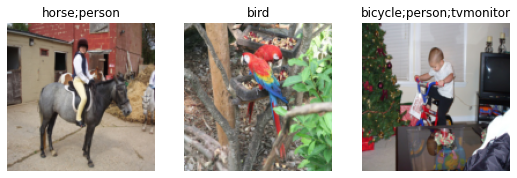

In [23]:
dls.show_batch(nrows=1, ncols=3)

In [24]:
learn = cnn_learner(dls, resnet18)

/usr/local/lib/python3.7/dist-packages/fastai/vision/learner.py:287: UserWarning: `cnn_learner` has been renamed to `vision_learner` -- please update your code
  warn("`cnn_learner` has been renamed to `vision_learner` -- please update your code")
/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:136: UserWarning: Using 'weights' as positional parameter(s) is deprecated since 0.13 and will be removed in 0.15. Please use keyword parameter(s) instead.
  f"Using {sequence_to_str(tuple(keyword_only_kwargs.keys()), separate_last='and ')} as positional "
/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download

  0%|          | 0.00/44.7M [00:00<?, ?B/s]

In [29]:
if torch.cuda.is_available():
    learn.model.cuda()

In [32]:
x, y = dls.train.one_batch()
activs = learn.model(x)
activs.shape

torch.Size([64, 20])